# Fairness Sandox

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
%pip install aif360
%pip install fairlearn
%pip install imbalanced-learn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached aif360-0.4.0-py3-none-any.whl (175 kB)
     |████████████████████████████████| 7.2 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 280 kB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 356 kB 21.4 MB/s eta 0:00:01
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Using cached pluggy-0.13.1-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 97 kB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 236 kB 18.5 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 12.0 MB/s eta 0:00:01
Using legacy setup.py install for shap, since package 'wheel' is not installed.
Using legacy setup.py install for memory-profiler, since package '

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Data

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = [],
                 sens_attr = '', has_sens_attr = True,
                 sep = '', synthetic = False):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.has_sens_attr = has_sens_attr
        if has_sens_attr:
            self.sens_attr = sens_attr
        if not synthetic:
            self.df = pd.read_csv(path, sep = sep)

In [3]:
# collection of datasets is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        raise TypeError("Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

### Popular Datasets

In [4]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols_adult = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols_adult = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols_adult, num_cols_adult, sep = ",", sens_attr = 'race')

add_dataset(adult_income)

In [5]:
cat_cols_por = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num_cols_por = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_por", path='Datasets/student-por.csv',
                    cat_cols=cat_cols_por, num_cols=num_cols_por, sep = ";", sens_attr = 'sex'))

### Synthetic Data Generation

#### Helper Functions

In [6]:
# create binary sensitive attribute
def get_sensitive_feat(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    sens_feat = np.vstack((minority, majority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(sens_feat)
    
    return sens_feat

In [7]:
def get_cat_feats(num_cat_feats, cat_feats_levels, n):
    cat_feats = []
    for i in range(num_cat_feats):
        levels = cat_feats_levels[i]
        if levels < 2:
            raise ValueError("Categorical features must have at least 2 classes!")
        vals = np.arange(levels)
        cat = np.random.choice(vals, n, [0.5,0.5]).reshape(n, 1)
        cat_feats.append(cat)
    return np.hstack((cat_feats))

In [8]:
def distribution_plot(outcome_min = [], outcome_maj = [], outcome = [],
                      threshold_min = 0.5, threshold_maj = 0.5,
                      diff_dist = False):
    
    if diff_dist:

        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.hist(outcome_min,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Minority")

        plt.subplot(1,2,2)
        plt.hist(outcome_maj,label='continuous outcome',bins='auto')
        plt.axvline(threshold_maj,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Majority")
        plt.show()
        
    else:
        
        plt.figure(figsize=(17,7))
        plt.subplot(1,2,1)
        plt.hist(outcome,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Distribution of Outcomes")
        plt.show()

In [9]:
def get_attribute_names(df, num_numerical_cols, num_cat_cols):
    col_names = []
    for i in range(num_numerical_cols):
        col_names.append('num' + str(i+1))
    for i in range(num_cat_cols):
        col_names.append('cat' + str(i+1))
    col_names.append('sens_feat')
    col_names.append('outcome')
    
    return col_names

In [10]:
# flip labels with probability eta
def flip_labels(df_synthetic, label_noise):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= label_noise:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

#### Main Function

In [11]:
'''
Parameters:

    n is the total number of examples in the dataset
    
    num_numerical_feats is number of numerical features
        each numerical feature is drawn from a
        multivariate normal distribution with mean 0
        
    num_cat_feats is number of categorical features
    
    cat_levels is an array where each element is the number
        of levels for each categorical feature
        len(cat_levels) = num_cat_feats
        
    r is the proportion of examples in the minority group
        (1-r) is proportion of examples in majority group
        
    label_noise is in [0,1]
    
    diff_dist is true if minority and majority have different
        underlying sampling distributions
        
    show_vis displays the distribution of outcomes

'''

def get_synthetic_data(n, r, num_numerical_feats, num_cat_feats,
                       cat_levels = [], label_noise = 0, 
                       diff_dist = False, show_vis = False):
    
    assert 0 < r < 1, "R must be in [0,1]"
    num_min = int(n*r)
    num_maj = n - num_min
    
    cat_probs = list(np.multiply(np.ones(num_cat_feats),0.5))
    
    # numerical feature params
    means = list(np.zeros(num_numerical_feats))
    cov_matrix = list(np.identity(num_numerical_feats))
    
    # generating the features
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)
    num_features = np.concatenate((num_features_min, num_features_maj))
        
    # binary sensitive attribute, 0: minority, 1: majority
    sens_feat = get_sensitive_feat(r=r, n=n) 
    
    assert len(cat_levels) == num_cat_feats, \
    "Each categorical feature must have a specification for its number of levels"
    cat_feats = get_cat_feats(num_cat_feats, cat_levels, n)
    
    # generating outcomes (continuous and binary)
    if diff_dist:
        # causal effect params
        effect_param_min = [0.5, -0.2, 0.1] 
        effect_param_maj = [-0.7, 0.5, 1.5]
        outcome_continuous_min = 1/(1+np.exp(-np.matmul(num_features_min,effect_param_min))) # logit model + no added noise
        outcome_continuous_maj = 1/(1+np.exp(-np.matmul(num_features_maj,effect_param_maj)))
        outcome_binary_min = np.where(outcome_continuous_min >= 0.5, 1, 0) # logistic decision boundary
        outcome_binary_maj = np.where(outcome_continuous_maj >= 0.5, 1, 0)
        outcome_binary = np.hstack((outcome_binary_min, outcome_binary_maj)).reshape(n,1)
        if show_vis:
            distribution_plot(outcome_continuous_min, outcome_continuous_maj, diff_dist=True)
    else:
        effect_param = [0.5, -0.2, 0.1] 
        outcome_continuous = 1/(1+np.exp(-np.matmul(num_features,effect_param))) # logit model + no added noise
        outcome_binary = np.where(outcome_continuous >= 0.5, 1, 0).reshape(n,1) # logistic decision boundary
        if show_vis:
            distribution_plot(outcome=outcome_continuous, diff_dist=False)

    
    temp_data = np.hstack((num_features, cat_feats, sens_feat, outcome_binary))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = get_attribute_names(df_synthetic, num_numerical_feats, num_cat_feats)
    
    assert 0 <= label_noise < 1, "Label noise must be in [0, 1)"
    if label_noise != 0:
        df_synthetic = flip_labels(df_synthetic, label_noise)
    
    # add to dictionary of datasets
    path_synthetic = 'Datasets/synthetic_data.csv'
    df_synthetic.to_csv(path_synthetic)
    add_dataset(Dataset('synthetic', path_synthetic, cat_cols=[], num_cols=[], synthetic=True, sens_attr = "sens_feat"))
    
    return df_synthetic

# example usage
df_synthetic = get_synthetic_data(1000, 0.25, 3, 2, [2,3], diff_dist=True, label_noise = 0.1)

# EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [13]:
# take a peek at the first few data points
df_synthetic.head()

,num1,num2,num3,cat1,cat2,sens_feat,outcome
0,0.747401,-0.217746,1.550649,0.0,1.0,0.0,1.0
1,0.548340,-1.173483,-0.408274,1.0,2.0,0.0,0.0
2,0.553826,-0.094605,0.736796,1.0,0.0,1.0,1.0
3,-0.381396,-0.465415,-0.184250,0.0,1.0,0.0,0.0
4,1.270332,-0.119034,-0.434270,0.0,2.0,1.0,0.0


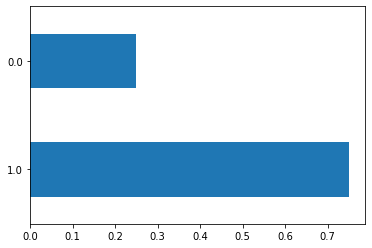

In [14]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
plot_counts(df_synthetic, 'sens_feat')

0.0
1.0


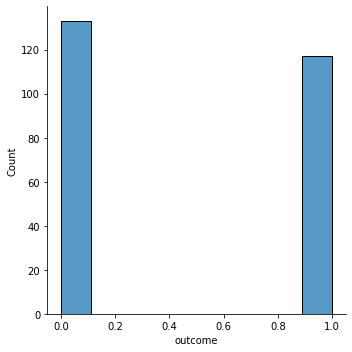

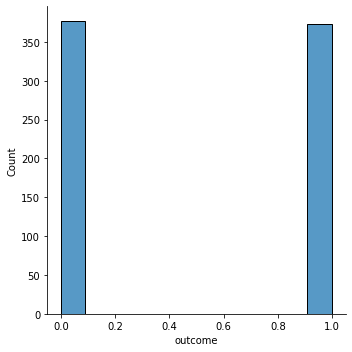

In [15]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
group_by_plot(df_synthetic, 'sens_feat', 'outcome')

# Preparation

### Train/Test Split

NOTES: 
1. Whether you input your own data, choose one of our provided datasets, or generate synthetic data, we will consider this to be the UNBIASED GROUND TRUTH.
2. Then, we will split the data, with the first part being the data which we will inject bias into and the second part being the unbiased ground truth testing data.



In [16]:
'''
    train_ratio: is the proportion of data examples in the training set
        (1-train_ratio is proportion in unbiased testing set)
'''
def train_test_split(df, train_ratio = 0.5):
    
    df_train = df.loc[range(0,int(len(df_synthetic)*train_ratio)), :]
    df_test = df_synthetic.loc[range(int(len(df_synthetic)*train_ratio)+1, len(df_synthetic)), :]
    
    return df_train, df_test

df_train, df_test = train_test_split(df_synthetic)

### Data Preprocessing

In [17]:
# format data
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

In [18]:
'''

This function separates the minority and majority classes

Parameters:
    
    sens_attr: sensitive attribute
    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class

'''
def get_maj_min(df, sens_attr, maj_val, min_val):
    assert sens_attr in list(df.columns), "Sensitive attribute must be a column in the dataframe!"
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    return df_majority, df_minority

df_majority, df_minority = get_maj_min(df_train, 'sens_feat', 1, 0)

#### One-Hot Encoding (ONLY for non-synthetic data)

In [19]:
# OHE categorical features (prompt for user's choice here?)

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))

NameError: name 'X' is not defined

In [20]:
# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

sens_attrs_true = [df_test[datasets['synthetic'].sens_attr]]

# Bias Injection (TODO - put different biases into another file?)

### List of Biases
1. Under-Sampling (of Minority)
2. Over-Sampling (of Majority)
3. Omitted Variable
4. Label Noise

#### Under-Sampling Minority Class

Note: you will need to input $\beta$, which is the probability of deleting an example from the minority class. For example, if $\beta = 0.25$ then each example in the training data will be deleted with probability $0.25$, which will result in approximately $25\%$ of the total minority class examples being deleted.

In [21]:
'''

This function performs the under-sampling bias injection

'''
def under_sample(df_minority, beta):
    X_min = df_minority.iloc[:, :].values
    cols = df_minority.columns
    
    # delete each example with probability beta
    for i in range(len(X_min)):
        if random.uniform(0,1) <= beta:
            X_min = np.delete(X_min, 0, axis=0)
    
    df_minority = pd.DataFrame(pd.DataFrame(X_min))
    df_minority.columns = cols
    return df_minority


'''

Parameters:

    beta = probability of deleting example from minority
    sens_attr: sensitive attribute
    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class
    positive: true if only under-sampling POSITIVELY labeled examples from minority
        if false: under-sampling positively and negatively labeled examples

'''
def under_sampling(df_train, beta, sens_attr,
                    maj_val, min_val, positive = False):
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    if positive:
        label = list(df_train.columns)[-1]
        df_minority_negative = df_minority[df_minority[label] == 0.0]
        df_minority_positive = df_minority[df_minority[label] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])
    
        # under-sampling process
        df_undersampled = under_sample(df_minority_positive, beta)
        
    else:
        df_total = df_majority
        df_undersampled = under_sample(df_minority, beta)

    # combine undersampled and original majority class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

#### Over-Sampling Majority Class

Note: you can either choose to randomly over-sample existing examples or generate new samples by interpolation using SMOTE and ADASYN

In [22]:
'''

Parameters:

    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class
    sens_attr: sensitive attribute
    over_amt: amount of over-sampling to be applied to majority
        e.g. over_amt = 2 means twice as many samples in majority

'''
def random_over_sampling(df_train, sens_attr, 
                         maj_val, min_val, over_amt = 2):
    df_majority = df_train[df_train[sens_attr] == maj_val]
    df_minority = df_train[df_train[sens_attr] == min_val]
    
    df_oversampled = df_majority.sample(int(over_amt)*len(df_majority), replace = True)
    
    # combine oversampled and original majority class to create dataset
    df_concat = pd.concat([df_oversampled,df_minority])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

In [23]:
from imblearn.over_sampling import *
# to avoid warning
pd.options.mode.chained_assignment = None

'''

Parameters:

    maj_val: value of sens_attr which indicates majority class
    min_val: value of sens_attr which indicates minority class
    sens_attr: sensitive attribute
    over_amt: amount of over-sampling to be applied to majority
        e.g. over_amt = 2 means twice as many samples in majority
    type: if 1 then SMOTE, if 2 then ADASYN

'''
def over_sampling(df_train, sens_attr, 
          maj_val, min_val, over_amt = 2, type = 1):
    
    assert type in [1,2], "Type must be 1 or 2, see comments!"
    
    cols = df_train.columns
    
    df_majority_X = df_train[df_train[sens_attr] == maj_val].drop('outcome', axis = 1)
    df_majority_y = df_train[df_train[sens_attr] == maj_val]['outcome']
    df_minority_X = df_train[df_train[sens_attr] == min_val].drop('outcome', axis = 1)
    df_minority_y = df_train[df_train[sens_attr] == min_val]['outcome']
    
    over_sample_amt = int(len(df_majority_X) * over_amt)
    
    # make original minority class into majority with label 0
    df_minority_flipped = df_minority_X.sample(over_sample_amt, replace = True)
    df_minority_flipped['outcome'] = np.zeros((len(df_minority_flipped),1))
    
    # make original majority have all label 0 (so it's the minority now)
    df_majority_X['outcome'] = np.ones((len(df_majority_X),1))
    df_majority = df_majority_X
    
    df_total = pd.concat([df_minority_flipped, df_majority])
    
    X_total = df_total.iloc[:, :-1].values
    y_total = df_total.iloc[:, -1].values
    
    if type == 1:
        over_sampler = SMOTE(random_state = 42, sampling_strategy = 'minority')
    else:
        over_sampler = ADASYN(random_state = 42, sampling_strategy = 'minority')
    
    X_total_resampled, y_total_resampled = over_sampler.fit_resample(X_total, y_total)
    
    df_res = pd.DataFrame(X_total_resampled)
    df_res['outcome'] = y_total_resampled
    df_res.columns = cols
    
    df_oversampled = df_res[df_res[sens_attr] == maj_val]
    oversampled_labels = df_majority_y.sample(len(df_oversampled), replace = True).values
    
    labels = oversampled_labels
        
    df_oversampled['outcome'] = labels
    
    # combine oversampled and original majority class to create dataset
    df_concat = pd.concat([df_oversampled,df_minority])
    
    return df_concat.sample(frac=1) # reshuffle rows of dataframe randomly

#### Omitted Variable

Note: if you choose to remove the sensitive feature, you will no longer be able to impose a fairness intervention! Resulting comparisons will simply be between regular ml models trained with and without the sensitive attribute.

In [24]:
# must input a Dataset object
def omitted_variable(df, short_name, col_to_del, is_sens_attr = False):
    assert col_to_del in list(df.columns), "Column to delete must be a column in the dataframe!"
    assert short_name in datasets.keys(), "Dataset with that short name doesn't exist!"
    
    if is_sens_attr:
        datasets[short_name].has_sens_attr = False
        
    return df.drop(col_to_del, axis = 1)

#### Label Noise Bias

In [25]:
# flip labels with probability label_noise
def label_noise(df, label_noise):
    
    df_bias = df.copy()
    
    labels = df_bias['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= label_noise:
            labels[i] = 1 if labels[i] == 0 else 0
    df_bias['outcome'] = labels
    
    return df_bias

### Bias Selection

In [26]:
biases = dict()

def add_bias(bias_func, short_name):
    biases[short_name] = bias_func

# example usage
add_bias(under_sampling, 'under_sampling')
add_bias(omitted_variable, 'omitted_variable')
add_bias(random_over_sampling, 'random_over_sampling')
add_bias(over_sampling, 'over_sampling')
add_bias(label_noise, 'label_noise')

### Bias Injection

In [27]:
#df_bias = biases['under_sampling'](df_train, 0.5, 'sens_feat', 1, 0, True)
#df_bias = biases['omitted_variable'](df_train, 'synthetic', 'num1', is_sens_attr=False)
#df_bias = biases['random_over_sampling'](df_train, 'sens_feat', 1, 0, 2)
#df_bias = biases['over_sampling'](df_train, 'sens_feat', 1, 0, 2, type=2)
df_bias = biases['label_noise'](df_train, 0.1)

# for fairness measures later
if datasets['synthetic'].has_sens_attr:
    df_sens = df_bias[datasets['synthetic'].sens_attr]

# format data
X_bias = df_bias.iloc[:, :-1].values
y_bias = df_bias.iloc[:, -1].values

### Post-Injection Visualization (TODO - update for each type of bias)

# Model

### Model Selection + Training (TODO: modularize)

In [28]:
# modularize and add data struct of different ml techniques

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias, y_bias)
y_pred_bias = classifier_bias.predict(X_bias)
y_pred_bias_on_true = classifier_bias.predict(X_true)

sens_feat_true = df_test['sens_feat']
sens_feat_bias = df_sens

### Model Performance (TODO: modularize)

In [29]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Accuracy of Ground Truth Model on Ground Truth Data:  0.8216432865731463
Accuracy of Biased Model on Biased Data:  0.756
Accuracy of Biased Model on Ground Truth Data:  0.6773547094188377


In [46]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(metrics=accuracy_score,y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_truth, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.8216432865731463
Group Accuracy :  sens_feat
0.0    0.838462
1.0    0.815718
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.4729458917835671
Group Selection Rate :  sens_feat
0.0    0.469231
1.0    0.474255
Name: selection_rate, dtype: object


# Fairness Intervention

In [31]:
constraints = [EqualizedOdds(), DemographicParity(), ErrorRateParity(),
               FalsePositiveRateParity(), TruePositiveRateParity()]

In [32]:
constraint = DemographicParity()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_feat_true)
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [33]:
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias, y_bias, sensitive_features = sens_feat_bias)
y_pred_mitigated_bias = mitigator_bias.predict(X_bias)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [34]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.8216432865731463
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.6833667334669339


In [47]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated_true, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated_true, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.8216432865731463
Group Accuracy :  sens_feat
0.0    0.838462
1.0    0.815718
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.4729458917835671
Group Selection Rate :  sens_feat
0.0    0.469231
1.0    0.474255
Name: selection_rate, dtype: object


In [48]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated_bias_on_true, sensitive_features = sens_feat_true)
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.6833667334669339
Group Accuracy :  sens_feat
0.0    0.715385
1.0    0.672087
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.531062124248497
Group Selection Rate :  sens_feat
0.0    0.515385
1.0    0.536585
Name: selection_rate, dtype: object


# Trade-Off Visualization

In [37]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(bias_amts, classifier, X_true, y_true, 
                           df_train, sensitive_feature = "cat",
                           is_synthetic = False,
                           apply_fairness = False, verbose = False):
    
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    
    count = 0

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    for bias in bias_amts:
        
        df_bias = biases['over_sampling'](df_train, 'sens_feat', 1, 0, 2, type=2)
        df_sens = df_bias[sensitive_feature]

        # format data
        X_bias = df_bias.iloc[:, :-1].values
        y_bias = df_bias.iloc[:, -1].values
        
        if not is_synthetic:
            # OHE
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
            X_bias_true = np.array(ct.fit_transform(X_bias))
        else:
            X_bias_true = X_bias
        
        y_bias_true = df_bias.iloc[:, -1].values
        
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = DemographicParity()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", count)
            count +=1

    return bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [38]:
def accuracy_visualizations(bias_amts,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()

In [39]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated):
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Amount of Bias (number of minority samples removed)")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend()
    plt.show()

In [40]:
classifier = LogisticRegression()

bias_amts = np.divide(list(range(10,-1,-1)),10)

bias_amts, accuracy_on_biased, accuracy_on_true, \
           accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(bias_amts, classifier, X_true, y_true,
                       df_train, "sens_feat", is_synthetic=True,
                       apply_fairness=True, verbose=True)

Finished Iteration:  0
Finished Iteration:  1
Finished Iteration:  2
Finished Iteration:  3
Finished Iteration:  4
Finished Iteration:  5
Finished Iteration:  6
Finished Iteration:  7
Finished Iteration:  8
Finished Iteration:  9
Finished Iteration:  10


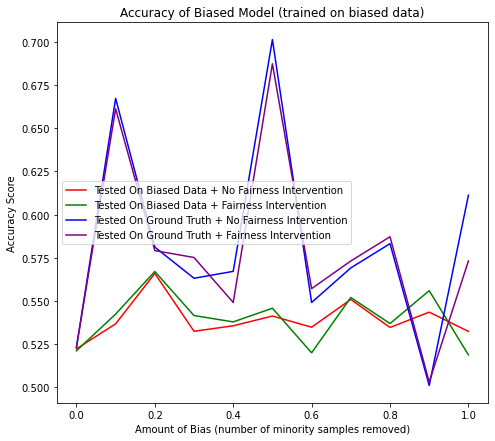

In [41]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                     accuracy_on_biased_mitigated, accuracy_on_true_mitigated)